In [4]:
!pip uninstall opencv-python opencv-contrib-python opencv-contrib-python-headless -y

Found existing installation: opencv-contrib-python 4.9.0.80
Uninstalling opencv-contrib-python-4.9.0.80:
  Successfully uninstalled opencv-contrib-python-4.9.0.80


In [5]:
!pip install opencv-contrib-python

  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (68.3 MB)


In [6]:
!pip install imutils

In [7]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import wandb
wandb.init(mode="disabled")
import shutil

2024-04-26 17:36:39.188892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 17:36:39.189044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 17:36:39.324611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
import cv2
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

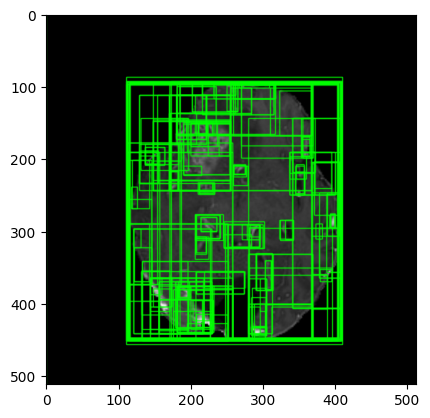

In [9]:
path = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/train/00095_170.jpg"
im = cv2.imread(path)
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()

# num_regions = 2000
# rects = rects[:num_regions]

imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [10]:
len(rects)

250

In [11]:
def get_iou(bb1, bb2):
#     print(bb1)
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [12]:
train_images=[]
train_labels=[]
train_bboxes=[]
annot = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/labels/train"
path = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/train"
for e,i in enumerate(os.listdir(annot)):
    try:
        gtvalues=[]
        filename = i.split(".")[0]+".jpg"
        image = cv2.imread(os.path.join(path,filename))
        h, w, _ = image.shape
        df = pd.read_csv(os.path.join(annot,i))
        for row in df.iterrows():
            label = int(float(row[1].iloc[0].split(" ")[0]))
            x2 = int(float(row[1].iloc[0].split(" ")[1]) * w)
            y2 = int(float(row[1].iloc[0].split(" ")[2]) * h)
            x1 = int(float(row[1].iloc[0].split(" ")[3]) * w)
            y1 = int(float(row[1].iloc[0].split(" ")[4]) * h)
            gtvalues.append({"label":label, "x1":x1,"x2":x2,"y1":y1,"y2":y2})
            
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()
        imout = image.copy()
        
        positive_count = 0
        negative_count = 0
        
        flag = 0
        fflag = 0
        bflag = 0
        for e,rect in enumerate(rects):
            if e < 2000 and flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = rect
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if positive_count < 30:
                        if iou > 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            positive_count += 1
#                             train_bboxes.append([x, y, x+w, y+h])
                            train_bboxes.append([x, y, w, h])
                    else :
                        fflag =1
                    if negative_count <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            negative_count += 1
                            train_bboxes.append([x, y, w, h])
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    print("inside")
                    flag = 1
    except Exception as e:
        print("error in "+filename)
        continue

inside


In [13]:
# Chuyển đổi train_images thành mảng numpy
train_images_array = np.array(train_images)

# Chuyển đổi train_labels thành mảng numpy
train_labels_array = np.array(train_labels)

# Chuyển đổi train_bboxes thành mảng numpy
# Đầu tiên, xác định số lượng hộp giới hạn tối đa trong một mẫu
max_num_bboxes = max(len(bboxes) for bboxes in train_bboxes)
# Tạo một mảng numpy để chứa các hộp giới hạn, sử dụng giá trị -1 để đánh dấu các hộp giới hạn không sử dụng
train_bboxes_array = np.full((len(train_bboxes), max_num_bboxes), -1, dtype=np.float32)
# Điền các hộp giới hạn vào mảng
for i, bboxes in enumerate(train_bboxes):
    for j, bbox in enumerate(bboxes):
        train_bboxes_array[i, j] = bbox

# Kiểm tra kích thước của các mảng
print("Kích thước của train_images_array:", train_images_array.shape)
print("Kích thước của train_labels_array:", train_labels_array.shape)
print("Kích thước của train_bboxes_array:", train_bboxes_array.shape)


Kích thước của train_images_array: (471, 224, 224, 3)
Kích thước của train_labels_array: (471,)
Kích thước của train_bboxes_array: (471, 4)


In [14]:
train_bboxes_array

array([[ 92., 208.,  14.,  14.],
       [ 34., 159.,  41.,  50.],
       [ 85., 167.,  25.,  29.],
       ...,
       [ 23., 130.,  34.,  85.],
       [ 23., 124.,  51.,  91.],
       [ 23.,  70.,  51., 145.]], dtype=float32)

In [15]:
train_labels_array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [16]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
tf.config.set_soft_device_placement(True)

In [17]:
# vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=True)
for layer in vggmodel.layers[:-2]:
    layer.trainable = False
vggmodel.summary()


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 20,878,312 (79.64 MB)

 Non-trainable params: 117,479,232 (448.15 MB)

In [18]:
x = vggmodel.get_layer('flatten')
last_output =  x.output

In [19]:
x = Dense(1, activation='sigmoid', name='predictions')(last_output)
model = Model(inputs=vggmodel.input, outputs=x)

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
x = model.get_layer('flatten').output
model_extractfeatures = Model(inputs=model.input, outputs=x)

In [22]:
len(train_images)

471

In [23]:
# extract features
train_features = model_extractfeatures.predict(train_images_array)
# val_features = model_extractfeatures.predict(val_images_svm)
train_features.shape

2024-04-26 17:41:22.349476: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-04-26 17:41:22.349541: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-04-26 17:41:22.349556: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-04-26 17:41:22.349568: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-04-26 17:41:22.349581: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-04-26 17:41:22.349601: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-04-26 17:41:22.349612: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-04-26 17:41:22.349622: E external/local_xla/xla/se

 4/15 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

I0000 00:00:1714153297.662562     152 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

2024-04-26 17:41:39.253973: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150528: 4.38462, expected 3.57489
2024-04-26 17:41:39.254075: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150529: 4.90744, expected 4.09771
2024-04-26 17:41:39.254092: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150530: 5.28052, expected 4.47079
2024-04-26 17:41:39.254108: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150531: 5.54085, expected 4.73112
2024-04-26 17:41:39.254125: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150532: 4.33636, expected 3.52662
2024-04-26 17:41:39.254136: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150533: 5.02811, expected 4.21837
2024-04-26 17:41:39.254148: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150534: 5.7047, expected 4.89496
2024-04-26 17:41:39.2

15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 816ms/step


(471, 25088)

In [24]:
train_features.shape

(471, 25088)

In [25]:
reg_model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(25088,)),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(4, activation="sigmoid")
])

In [26]:
from keras.optimizers import Adam
# opt = Adam(learning_rate=0.0001)
opt = Adam()

In [27]:
reg_model.compile(loss = "mse", optimizer = opt)
reg_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,605,956 (6.13 MB)

 Trainable params: 1,605,956 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
reg_model.fit(train_features, np.array(train_bboxes), batch_size = 64, epochs= 10)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 11146.4600
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10471.5986
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10649.2812 
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10888.7871 
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10781.3809 
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10742.8350 
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10568.8213
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10903.2930 
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10542.6230 
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10832.2402 


In [29]:
box_offset = reg_model.predict(train_features)
box_offset.shape

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


(471, 4)

In [30]:
pred_boxes = box_offset + train_bboxes
pred_boxes.shape

(471, 4)

In [31]:
pred_boxes

array([[ 93., 209.,  15.,  15.],
       [ 35., 160.,  42.,  51.],
       [ 86., 168.,  26.,  30.],
       ...,
       [ 24., 131.,  35.,  86.],
       [ 24., 125.,  52.,  92.],
       [ 24.,  71.,  52., 146.]])

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
import joblib

In [33]:
clf = SVC(probability=True)
clf.fit(train_features, train_labels_array)
# save model 
joblib.dump(clf, './model_svm.pkl')

['./model_svm.pkl']

Regression

In [34]:
predictions = clf.predict(train_features)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [35]:
predictions_proba = clf.predict_proba(train_features)
predictions_proba[:3]

array([[0.96505294, 0.03494706],
       [0.96509503, 0.03490497],
       [0.98289103, 0.01710897]])

In [36]:
score_predictions = []
# bbox_predictions = []
for i in range(len(predictions_proba)):
    if predictions_proba[i][1] > 0.99:
        x, y, w, h = train_bboxes[i]
        # img = cv2.rectangle(img, (x, y), (w, h), (0, 255, 0), 3)
        score_predictions.append(predictions_proba[i][1])
#         bbox_predictions.append([x, y, w, h])

In [37]:
score_predictions

[]

In [38]:
bbox_predictions = np.array(pred_boxes)
bbox_predictions

array([[ 93., 209.,  15.,  15.],
       [ 35., 160.,  42.,  51.],
       [ 86., 168.,  26.,  30.],
       ...,
       [ 24., 131.,  35.,  86.],
       [ 24., 125.,  52.,  92.],
       [ 24.,  71.,  52., 146.]])

In [39]:
# from imutils.object_detection import non_max_suppression
# pick = non_max_suppression(bbox_predictions, probs=score_predictions, overlapThresh=0.3)
# pick

2024-04-26 17:42:10.532371: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.42855, expected 3.64542
2024-04-26 17:42:10.532442: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.87036, expected 5.08723
2024-04-26 17:42:10.532453: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.04003, expected 5.2569
2024-04-26 17:42:10.532461: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.22034, expected 5.43722
2024-04-26 17:42:10.532469: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.90026, expected 4.11714
2024-04-26 17:42:10.532478: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.21068, expected 4.42756
2024-04-26 17:42:10.532486: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.92061, expected 5.13748
2024-04-26 17:42:10.532494: E external/local_xla/xla/ser

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━

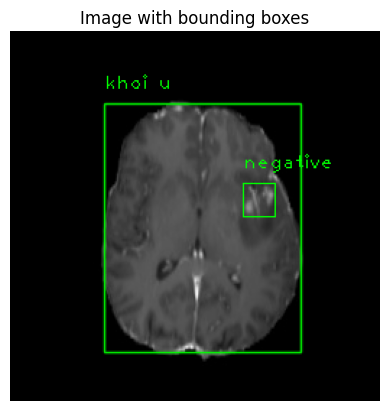

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

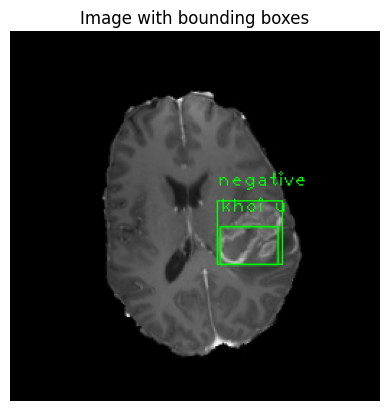

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

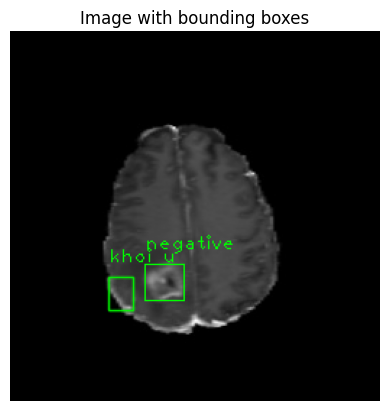

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

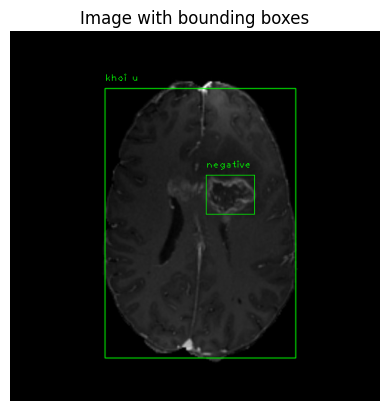

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

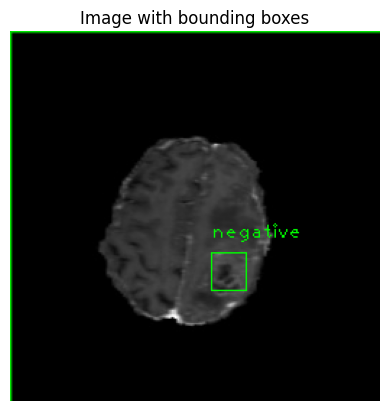

In [40]:
import os

z = 0
path = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test"
label_dir = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/labels/test"
img_path = os.listdir(path)[:5]

for e, i in enumerate(img_path):
    img = cv2.imread(os.path.join(path, i))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = img.copy()
    
    # Đọc nhãn từ tệp nhãn
    with open(os.path.join(label_dir, i.split('.')[0] + '.txt'), 'r') as f:
        labels = f.readline().split(' ')
    
    # Vẽ bounding box cho khu vực thực
    tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])
    
    if tumor_class == 1:
        color = (255, 0, 0)  # Màu đỏ
        label = 'positive'
    else:
        color = (0, 255, 0)  # Màu xanh lá cây
        label = 'negative'
    
    cv2.rectangle(imout, (x_pt1, y_pt1), (x_pt2, y_pt2), color, 1)
    cv2.putText(imout, label, (x_pt1, y_pt1-10), cv2.FONT_HERSHEY_PLAIN, 0.9, color, 1)
    
    classes = []
    scores = []
    boxes = []
    
    for e, result in enumerate(ssresults):
        if e < 2000:
            x, y, w, h = result
            timage = imout[y:y+h, x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation=cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            feat = model_extractfeatures.predict(img)
            out = clf.predict_proba(feat)
            
            if out[0][0] > 0.8:
                boxes.append(result)
                classes.append(1)
                scores.append(out.max())

    selected_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=1, iou_threshold=0.5)
    selected_boxes = tf.gather(boxes, selected_indices)
    
    for i, box in enumerate(selected_boxes):
        x, y, w, h = box[:4]
        x = int(x)
        y = int(y)
        w = int(w)
        h = int(h)
        
        if classes[i] == 1:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
            cv2.putText(imout, 'khoi u', (x, y-10), cv2.FONT_HERSHEY_PLAIN, 0.9, (0, 255, 0), 1)

    plt.figure()
    plt.imshow(imout)
    plt.title('Image with bounding boxes')
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

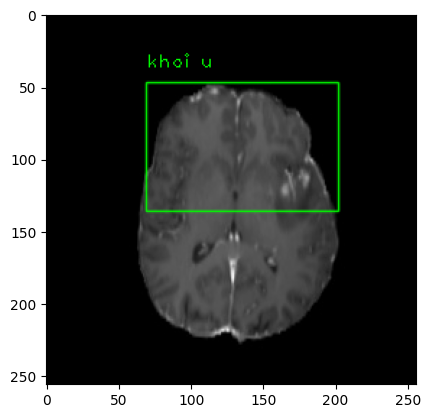

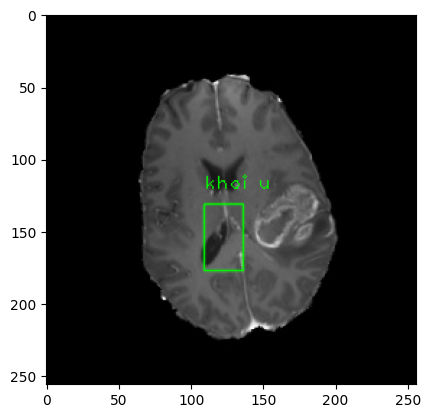

In [41]:
z=0
path = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test"
img_path = os.listdir(path)[:2]
# model_path = "/kaggle/working/ieeercnn_vgg16_1.keras"
# model = keras.saving.load_model(model_path, custom_objects=None, compile=True, safe_mode=True)
for e,i in enumerate(img_path):
    classes = []
    scores = []
    boxes = []
    z += 1
    img = cv2.imread(os.path.join(path,i))
    
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = img.copy()
    
    for e,result in enumerate(ssresults):
        if e < 2000:
            x,y,w,h = result
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            feat = model_extractfeatures.predict(img)

            offset = reg_model.predict(feat)

            out = clf.predict_proba(feat)

            if out[0][0] > 0.8:
                boxes.append(result + offset.squeeze(0))
                classes.append(1)
                scores.append(out.max())
#                 print(np.array(boxes).shape)
#             else:
#                 classes.append(0)
#             if out[0][1] > 0.95:
#                 cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

    selected_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=1, iou_threshold=0.5)
    selected_boxes = tf.gather(boxes, selected_indices)
    for i, box in enumerate(selected_boxes):
        x,y,w,h = box[:4]
        x = int(x)
        y = int(y)
        w = int(w)
        h = int(h)

        if classes[i] == 1:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
            cv2.putText(imout, 'khoi u', (x, y-10), cv2.FONT_HERSHEY_PLAIN, 0.9, (0, 255, 0), 1)
        else:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(imout, 'bth', (x, y-10), cv2.FONT_HERSHEY_PLAIN, 0.9, (0, 255, 0), 1)
            
    plt.figure()
    plt.imshow(imout)

# img_test = img.copy()
# for (startX, startY, endX, endY) in pick:
#     img_test = cv2.rectangle(img_test, (startX, startY), (endX, endY), (0, 255, 0), 3)
# plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))